In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy.special import roots_legendre
from matplotlib.ticker import LogLocator, NullFormatter
from scipy.interpolate import InterpolatedUnivariateSpline as iuSpline

In [2]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import optimize
from scipy.linalg import lu_factor, lu_solve
import discretize
import empymod


In [3]:
import Project
from Project import EMIP1D

In [4]:
res_air = 2e14
res_sea = 1/3
nlayers = 1
#nlayers = 10
#layer_thicknesses = 5.
seabed_depth = 1000.5
#seabed_depth = 1000.5
#depth = np.hstack([np.r_[0],seabed_depth+layer_thicknesses * np.arange(nlayers)])
depth = np.array([0,seabed_depth])
t = np.logspace(-8,-2, 121)
tstrt = 1e-6
tend = 1e-2
tindex = (t >= tstrt) & (t <= tend)
tplot = t[tindex]
model_base = {
    'src':  [1.5,1.5,0,1.5,1000, 1000],
    'rec': [0,0,1000,0,90],
    'depth': depth,
    'freqtime': t ,
    'signal': 0,
    'mrec' : True,
    'verb': 0
}

In [5]:
EMIP =  EMIP1D(model_base,res_air,res_sea,nlayers,tindex)

In [6]:
res_0 = 1/10 * np.ones(nlayers)
m_0 = np.log(res_0)

res_8 = 1/20 * np.ones(nlayers)
m_8 = np.log(res_8)
#tau = [0,0, 1e-4]
m_t = np.log(1e-4)*np.ones(nlayers)
#c = [0,0, 0.5]
m_c = 0.5*np.ones(nlayers)
m = (res_0 - res_8) / res_0

print(f'chargeability for obasercation{m}')
model_obs = np.hstack([m_0, m_8,m_t,m_c])
data_clean = EMIP.predicted_data(model_obs)



chargeability for obasercation[0.5]


In [7]:
relative_error=0.05
np.random.seed(0)
data_obs =  data_clean + np.random.randn(len(data_clean)) * relative_error * np.abs(data_clean)

In [8]:
res_0 = np.ones(nlayers)
m_0 = np.log(res_0)

res_8 = np.ones(nlayers)
m_8 = np.log(res_8)
#tau = [0,0, 1e-4]
m_t = np.log(1e-3)*np.ones(nlayers)
#c = [0,0, 0.5]
m_c = 0.6*np.ones(nlayers)
m = (res_0 - res_8) / res_0
print(f'chargeability for initial model{m}')

model_init = np.hstack([m_0, m_8, m_t, m_c])
data_init = EMIP.predicted_data(model_init)


chargeability for initial model[0.]


In [9]:
niter = 10
beta = 1
#model_SD, error, model_itr = EMIP.steepest_descent_linesearch(data_obs, model_init, niter)
model_SD, error, model_itr = EMIP.steepest_descent_Reg_LS(data_obs, model_init, niter,beta)

Steepest Descent 
 Initial phid = 1.01e+05 ,phim = 0.00e+00, error= 1.01e+05 
 i=   0, alpha= 2.44e-04, phid = 6.69e+04 ,phim = 5.85e+00, error= 6.69e+04 
 i=   1, alpha= 3.81e-06, phid = 4.39e+04 ,phim = 4.77e+00, error= 4.39e+04 
 i=   2, alpha= 7.63e-06, phid = 3.67e+04 ,phim = 4.13e+00, error= 3.67e+04 
 i=   3, alpha= 1.53e-05, phid = 3.66e+04 ,phim = 4.40e+00, error= 3.66e+04 
 i=   4, alpha= 1.53e-05, phid = 3.65e+04 ,phim = 4.26e+00, error= 3.65e+04 
 i=   5, alpha= 1.53e-05, phid = 3.65e+04 ,phim = 4.34e+00, error= 3.65e+04 
 i=   6, alpha= 1.53e-05, phid = 3.65e+04 ,phim = 4.30e+00, error= 3.65e+04 
 i=   7, alpha= 1.53e-05, phid = 3.65e+04 ,phim = 4.32e+00, error= 3.65e+04 
 i=   8, alpha= 3.05e-05, phid = 3.65e+04 ,phim = 4.29e+00, error= 3.65e+04 
 i=   9, alpha= 4.88e-04, phid = 1.37e+04 ,phim = 5.45e+00, error= 1.37e+04 


In [10]:
data_pred = (EMIP.predicted_data(model_SD))

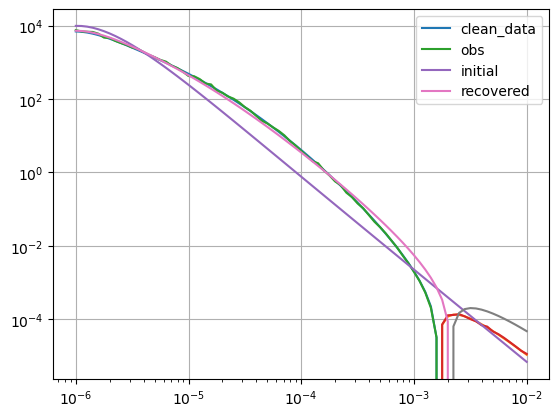

In [11]:
plt.loglog(tplot,data_clean,label = "clean_data")
plt.loglog(tplot,-data_clean)
plt.loglog(tplot,data_obs,label = "obs")
plt.loglog(tplot,-data_obs)
plt.loglog(tplot,data_init,label = "initial")
plt.loglog(tplot,-data_init)
plt.loglog(tplot,data_pred,label = "recovered")
plt.loglog(tplot,-data_pred)
plt.legend()
plt.grid()

In [12]:
ngrid = 20
mirgin = 0.1
itr_st = 0
m0_grid, m08_grid, cc_grid = EMIP.get_cc_grid(data_obs, 
        model_itr[itr_st:,0],
        model_itr[itr_st:,1],
        model_itr[-1,2],
        model_itr[-1,3],
        ngrid, mirgin
    )


In [13]:
res0_grid = np.exp(m0_grid)
res08_grid = np.exp(m08_grid)

In [14]:
res0_tr = np.exp(model_itr[itr_st:,0])
res08_tr = np.exp(model_itr[itr_st:,0]-model_itr[itr_st:,1])

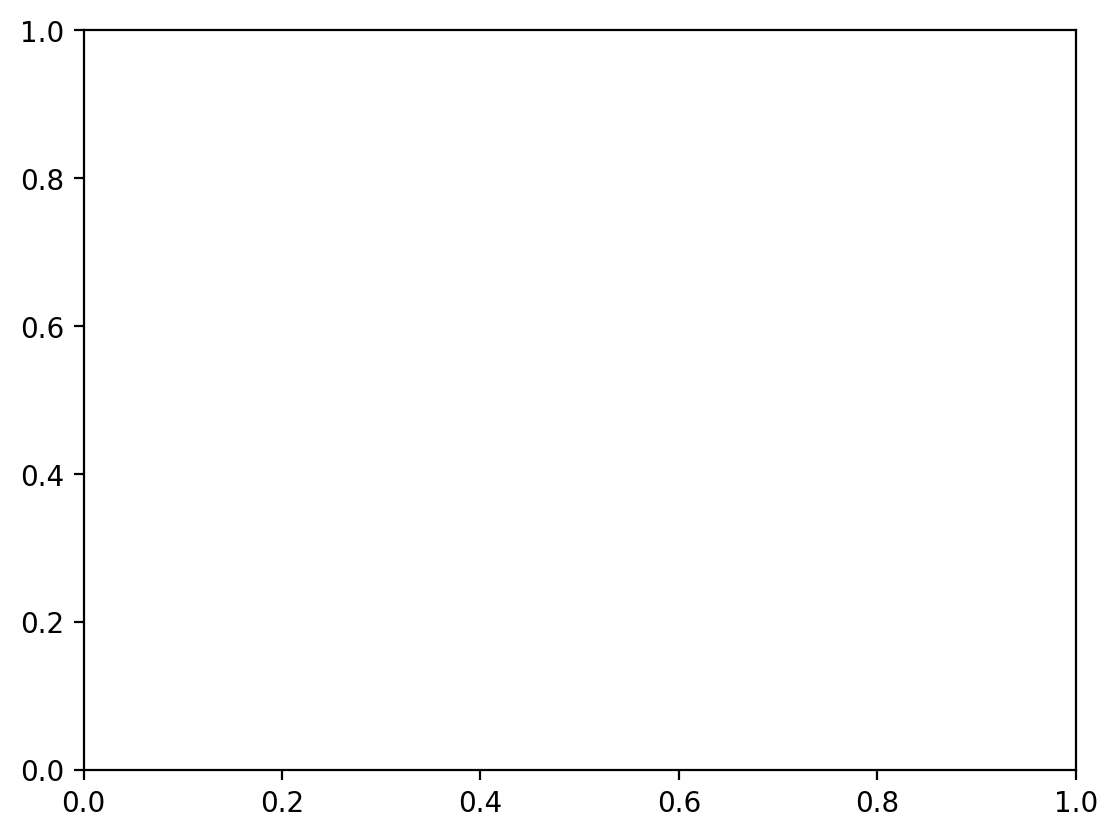

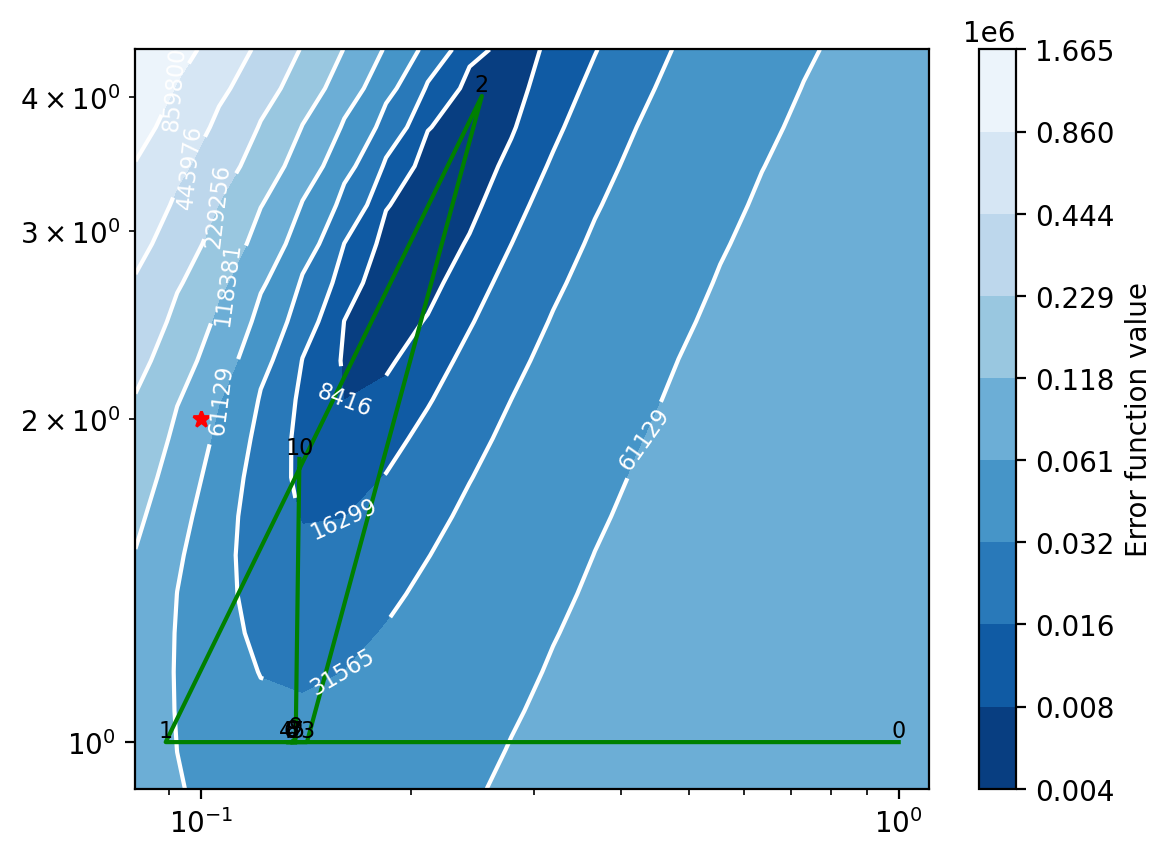

In [17]:
fig, ax = plt.subplots(1, 1,dpi=200)
levels = np.logspace( np.log10( np.min( cc_grid) ), np.log10( np.max(cc_grid) ),10)

# Create a logarithmically spaced colormap
cmap = plt.cm.Blues_r
norm = mcolors.LogNorm(vmin=np.min(cc_grid), vmax=np.max(cc_grid))

# Plotting
fig, ax = plt.subplots(1, 1, dpi=200)
CF = ax.contourf(res0_grid, res08_grid, cc_grid, levels=levels, cmap=cmap, norm=norm)
CS = ax.contour(res0_grid, res08_grid, cc_grid, levels=levels, colors="w")
CL = ax.clabel(CS, inline=True, fontsize=8)

CB = fig.colorbar(CF, ax=ax)
CB.set_label("Error function value")
plt.plot(res0_tr,res08_tr,"g")
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.plot(np.exp(model_obs[0]),np.exp(model_obs[0]-model_obs[1]),"r*")
#plt.plot(model_itr[itr_st:,0],model_itr[itr_st:,0]-model_itr[itr_st:,1],"k")
#CS = ax.contour(res0_grid,res8_grid,cc_grid.T, levels=10)
for i, (x, y) in enumerate(zip(res0_tr, res08_tr)):
    plt.text(x, y, str(i), fontsize=8, color='black', ha='center', va='bottom')


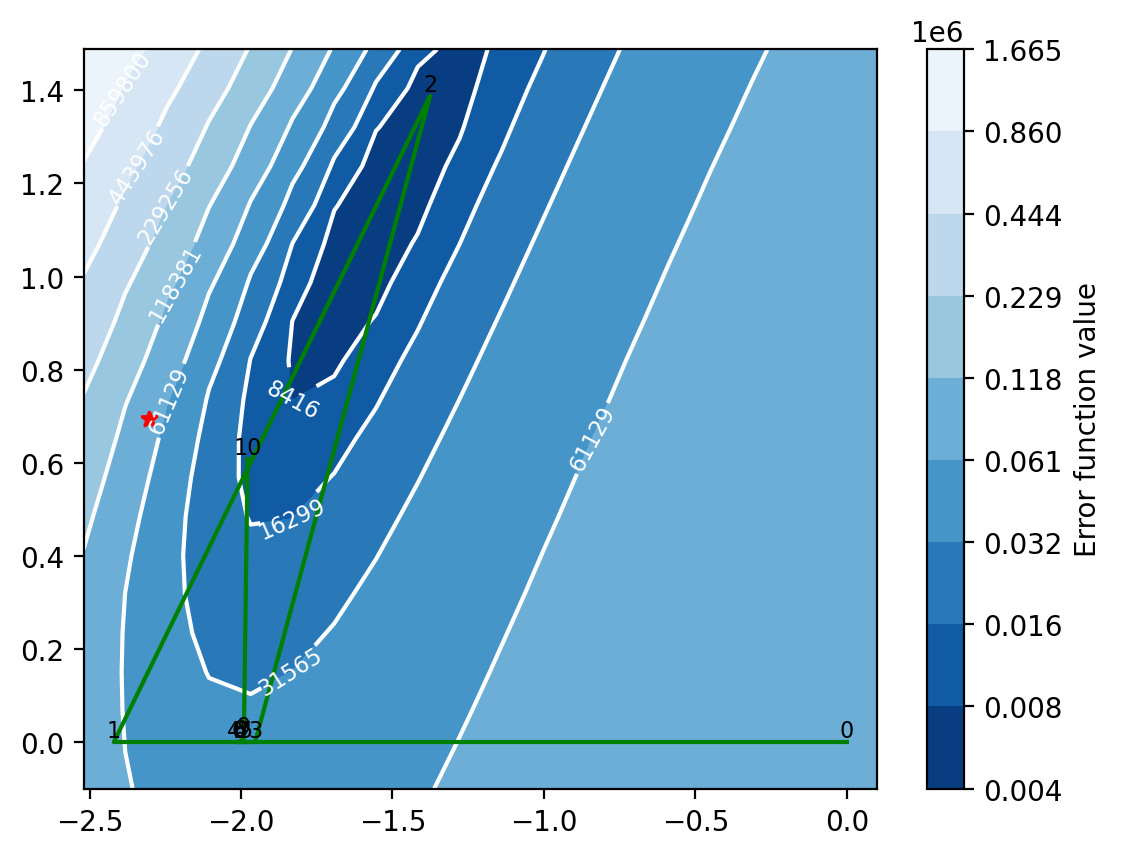

In [18]:
fig, ax = plt.subplots(1, 1,dpi=200)
levels = np.logspace( np.log10( np.min( cc_grid) ), np.log10( np.max(cc_grid) ),10)

# Create a logarithmically spaced colormap
cmap = plt.cm.Blues_r
norm = mcolors.LogNorm(vmin=np.min(cc_grid), vmax=np.max(cc_grid))

CF = ax.contourf(m0_grid, m08_grid, cc_grid, levels=levels, cmap=cmap, norm=norm)
CS = ax.contour(m0_grid, m08_grid, cc_grid, levels=levels, colors ="w")
CL = ax.clabel(CS, inline=True, fontsize=8)
CB = fig.colorbar(CF, ax=ax)
CB.set_label("Error function value")

plt.plot(model_itr[itr_st:,0],model_itr[itr_st:,0]-model_itr[itr_st:,1],"g")
plt.plot(model_obs[0],model_obs[0]-model_obs[1],"r*")
#CS = ax.contour(res0_grid,res8_grid,cc_grid.T, levels=10)
for i, (x, y) in enumerate(zip(model_itr[itr_st:,0], model_itr[itr_st:,0]-model_itr[itr_st:,1])):
    plt.text(x, y, str(i), fontsize=8, color='black', ha='center', va='bottom')
